<a href="https://colab.research.google.com/github/shubhampundhir/DeeplabV3plusRoad_Segmentation/blob/main/RoadSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pwd

/content


In [9]:
!git clone https://github.com/VainF/DeepLabV3Plus-Pytorch.git

Cloning into 'DeepLabV3Plus-Pytorch'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 705 (delta 25), reused 31 (delta 15), pack-reused 653
Receiving objects: 100% (705/705), 8.26 MiB | 28.20 MiB/s, done.
Resolving deltas: 100% (380/380), done.


In [10]:
!cd C:\Users\Shubham Pundhir\Documents\GitHub\DeepLabV3Plus-Pytorch

/bin/bash: line 1: cd: too many arguments


In [13]:
!cd DeepLabV3Plus-Pytorch/

In [14]:
!ls

DeepLabV3Plus-Pytorch  sample_data


In [15]:
cd /content/DeepLabV3Plus-Pytorch/

/content/DeepLabV3Plus-Pytorch


In [16]:
!ls

datasets  main.py  network     README.md	 samples
LICENSE   metrics  predict.py  requirements.txt  utils


In [17]:
!python predict.py

Traceback (most recent call last):
  File "/content/DeepLabV3Plus-Pytorch/predict.py", line 4, in <module>
    import utils
  File "/content/DeepLabV3Plus-Pytorch/utils/__init__.py", line 2, in <module>
    from .visualizer import Visualizer
  File "/content/DeepLabV3Plus-Pytorch/utils/visualizer.py", line 1, in <module>
    from visdom import Visdom
ModuleNotFoundError: No module named 'visdom'


In [18]:
pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=0af7c231875ee9124510d5d104c13a2b4796d639b5e919f584dbb8d24dac0639
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [ ]:
!python predict.py --input /content/DeepLabV3Plus-Pytorch/samples/1_image.png --dataset cityscapes --model deeplabv3plus_mobilenet --ckpt checkpoints/best_deeplabv3plus_mobilenet_cityscapes_os16.pth --save_val_results_to test_results

Device: cuda
[!] Retrain
100% 1/1 [00:01<00:00,  1.43s/it]


In [ ]:
!cat /content/DeepLabV3Plus-Pytorch/predict.py

from torch.utils.data import dataset
from tqdm import tqdm
import network
import utils
import os
import random
import argparse
import numpy as np

from torch.utils import data
from datasets import VOCSegmentation, Cityscapes, cityscapes
from torchvision import transforms as T
from metrics import StreamSegMetrics

import torch
import torch.nn as nn

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

def get_argparser():
    parser = argparse.ArgumentParser()

    # Datset Options
    parser.add_argument("--input", type=str, required=True,
                        help="path to a single image or image directory")
    parser.add_argument("--dataset", type=str, default='voc',
                        choices=['voc', 'cityscapes'], help='Name of training set')

    # Deeplab Options
    available_models = sorted(name for name in network.modeling.__dict__ if name.islower() and \
                              not (name.startswith("__") or name.startsw

In [ ]:
from torch.utils.data import dataset
from tqdm import tqdm
import network
import utils
import os
import random
import argparse
import numpy as np

from torch.utils import data
from datasets import VOCSegmentation, Cityscapes, cityscapes
from torchvision import transforms as T
from metrics import StreamSegMetrics

import torch
import torch.nn as nn

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

def get_argparser():
    parser = argparse.ArgumentParser()

    # Datset Options
    parser.add_argument("--input", type=str, required=True,
                        help="path to a single image or image directory")
    parser.add_argument("--dataset", type=str, default='voc',
                        choices=['voc', 'cityscapes'], help='Name of training set')

    # Deeplab Options
    available_models = sorted(name for name in network.modeling.__dict__ if name.islower() and \
                              not (name.startswith("__") or name.startswith('_')) and callable(
                              network.modeling.__dict__[name])
                              )

    parser.add_argument("--model", type=str, default='deeplabv3plus_mobilenet',
                        choices=available_models, help='model name')
    parser.add_argument("--separable_conv", action='store_true', default=False,
                        help="apply separable conv to decoder and aspp")
    parser.add_argument("--output_stride", type=int, default=16, choices=[8, 16])

    # Train Options
    parser.add_argument("--save_val_results_to", default=None,
                        help="save segmentation results to the specified dir")

    parser.add_argument("--crop_val", action='store_true', default=False,
                        help='crop validation (default: False)')
    parser.add_argument("--val_batch_size", type=int, default=4,
                        help='batch size for validation (default: 4)')
    parser.add_argument("--crop_size", type=int, default=513)


    parser.add_argument("--ckpt", default=None, type=str,
                        help="resume from checkpoint")
    parser.add_argument("--gpu_id", type=str, default='0',
                        help="GPU ID")
    return parser

def main():
    opts = get_argparser().parse_args()
    if opts.dataset.lower() == 'voc':
        opts.num_classes = 21
        decode_fn = VOCSegmentation.decode_target
    elif opts.dataset.lower() == 'cityscapes':
        opts.num_classes = 19
        decode_fn = Cityscapes.decode_target

    os.environ['CUDA_VISIBLE_DEVICES'] = opts.gpu_id
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device: %s" % device)

    # Setup dataloader
    image_files = []
    if os.path.isdir(opts.input):
        for ext in ['png', 'jpeg', 'jpg', 'JPEG']:
            files = glob(os.path.join(opts.input, '**/*.%s'%(ext)), recursive=True)
            if len(files)>0:
                image_files.extend(files)
    elif os.path.isfile(opts.input):
        image_files.append(opts.input)

    # Set up model (all models are 'constructed at network.modeling)
    model = network.modeling.__dict__[opts.model](num_classes=opts.num_classes, output_stride=opts.output_stride)
    if opts.separable_conv and 'plus' in opts.model:
        network.convert_to_separable_conv(model.classifier)
    utils.set_bn_momentum(model.backbone, momentum=0.01)

    if opts.ckpt is not None and os.path.isfile(opts.ckpt):
        # https://github.com/VainF/DeepLabV3Plus-Pytorch/issues/8#issuecomment-605601402, @PytaichukBohdan
        checkpoint = torch.load(opts.ckpt, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint["model_state"])
        model = nn.DataParallel(model)
        model.to(device)
        print("Resume model from %s" % opts.ckpt)
        del checkpoint
    else:
        print("[!] Retrain")
        model = nn.DataParallel(model)
        model.to(device)

    #denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # denormalization for ori images

    if opts.crop_val:
        transform = T.Compose([
                T.Resize(opts.crop_size),
                T.CenterCrop(opts.crop_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
    else:
        transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
    if opts.save_val_results_to is not None:
        os.makedirs(opts.save_val_results_to, exist_ok=True)
    with torch.no_grad():
        model = model.eval()
        for img_path in tqdm(image_files):
            ext = os.path.basename(img_path).split('.')[-1]
            img_name = os.path.basename(img_path)[:-len(ext)-1]
            img = Image.open(img_path).convert('RGB')
            img = transform(img).unsqueeze(0) # To tensor of NCHW
            img = img.to(device)

            pred = model(img).max(1)[1].cpu().numpy()[0] # HW
            colorized_preds = decode_fn(pred).astype('uint8')
            colorized_preds = Image.fromarray(colorized_preds)
            if opts.save_val_results_to:
                colorized_preds.save(os.path.join(opts.save_val_results_to, img_name+'.png'))

if __name__ == '__main__':
    main()

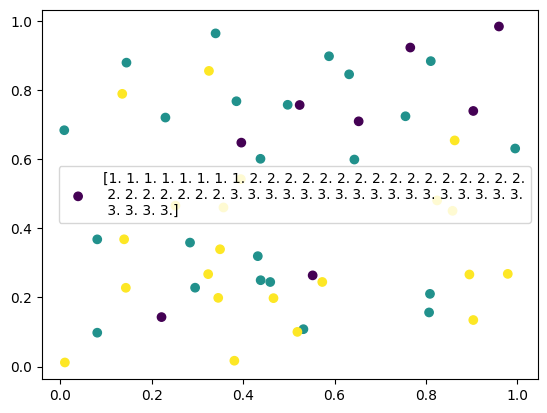

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(52,2)

labels = np.ones(x.shape[0])
labels[0:8] = 1
labels[8:31] = 2
labels[31:] = 3

plt.scatter(x[:,0], x[:,1], c = labels, label = labels)
plt.legend()
plt.show()

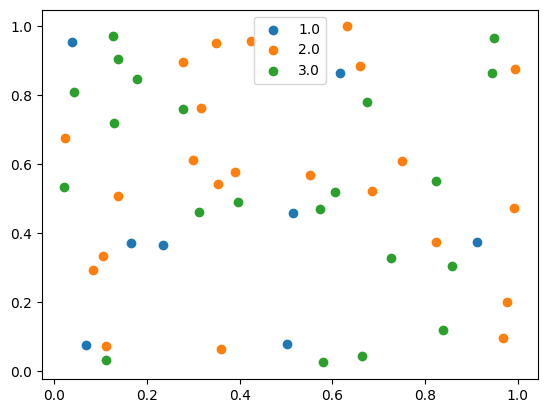

In [20]:
x = np.random.rand(52,2)

labels = np.ones(x.shape[0])
labels[0:8] = 1
labels[8:31] = 2
labels[31:] = 3


for i in np.unique(labels):
    plt.scatter(x[np.where(labels==i),0], x[np.where(labels==i),1], label=i)
plt.legend()
plt.show()

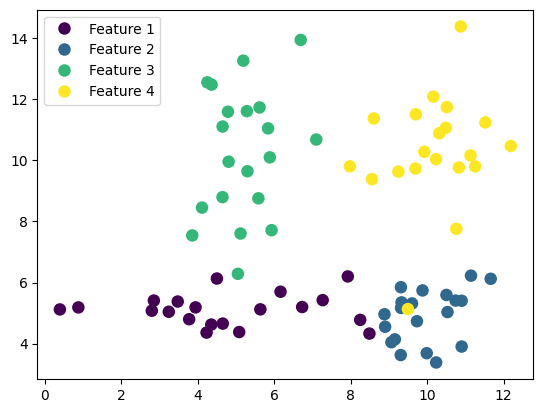

In [23]:
import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

x = [np.random.normal(5,2, size=20), np.random.normal(10,1, size=20),
     np.random.normal(5,1, size=20), np.random.normal(10,1, size=20)]
y = [np.random.normal(5,1, size=20), np.random.normal(5,1, size=20),
     np.random.normal(10,2, size=20), np.random.normal(10,2, size=20)]
c = [np.ones(20)*(i+1) for i in range(4)]

df = pd.DataFrame({"x":np.array(x).flatten(),
                   "y":np.array(y).flatten(),
                   "colors":np.array(c).flatten()})

size=81
sc = plt.scatter(df['x'], df['y'], s=size, c=df['colors'], edgecolors='none')

lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                        label="Feature {:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(df["colors"])]
plt.legend(handles=handles)
plt.show()